<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/scramjet_macormack_stable_species2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quasi-1D Scramjet Combustion Model with Species Transport and Arrhenius Kinetics
This notebook simulates compressible flow in a scramjet-like channel using a MacCormack solver. It includes:
- Species transport: fuel and product
- Local Arrhenius reaction kinetics
- Energy release in a combustion zone
- Dissipation and smoothing for stability


In [1]:
import numpy as np
import matplotlib.pyplot as plt

nx = 400
x = np.linspace(0, 1.0, nx)
dx = x[1] - x[0]

gamma = 1.4
R = 287.0
Cv = R / (gamma - 1)

# Initial flow conditions
rho = np.ones(nx) * 1.0
u = np.ones(nx) * 500.0
p = np.ones(nx) * 101325.0
T = p / (rho * R)

# Species
Y_F = np.ones(nx) * 0.05
Y_P = np.zeros(nx)

# Chemistry
Ea = 3e4
Q = 2e5
K = 2e6
reaction_zone = (x > 0.45) & (x < 0.55)

def compute_E(rho, u, T):
    return rho * (Cv * T + 0.5 * u**2)

E = compute_E(rho, u, T)

# Simulation
CFL = 0.4
t_final = 0.002
t = 0.0

while t < t_final:
    T = p / rho
    a = np.sqrt(gamma * p / rho)
    dt = CFL * dx / np.max(np.abs(u) + a)

    omega = K * Y_F * np.exp(-Ea / np.maximum(R * T, 1e-8))
    omega *= reaction_zone
    omega = np.clip(omega, 0, 1e5)

    # Predictor step
    F1 = rho * u
    F2 = rho * u**2 + p
    F3 = (E + p) * u

    rho_p = rho - dt/dx * (np.roll(F1, -1) - F1)
    u_p = (rho * u - dt/dx * (np.roll(F2, -1) - F2)) / rho_p
    E_p = E - dt/dx * (np.roll(F3, -1) - F3) + dt * Q * omega * rho

    T_p = (E_p / rho_p - 0.5 * u_p**2) / Cv
    p_p = rho_p * R * T_p

    # Corrector step
    F1_p = rho_p * u_p
    F2_p = rho_p * u_p**2 + p_p
    F3_p = (E_p + p_p) * u_p

    rho = 0.5 * (rho + rho_p - dt/dx * (F1_p - np.roll(F1_p, 1)))
    u = 0.5 * ((rho * u + rho_p * u_p - dt/dx * (F2_p - np.roll(F2_p, 1))) / rho)
    E = 0.5 * (E + E_p - dt/dx * (F3_p - np.roll(F3_p, 1))) + dt * Q * omega * rho

    T = (E / rho - 0.5 * u**2) / Cv
    p = rho * R * T

    Y_F = np.clip(Y_F - dt * omega, 0, 1)
    Y_P = 1.0 - Y_F

    Y_F = 0.5 * (np.roll(Y_F, 1) + np.roll(Y_F, -1))
    u = 0.5 * (np.roll(u, 1) + np.roll(u, -1))
    p = 0.5 * (np.roll(p, 1) + np.roll(p, -1))

    t += dt

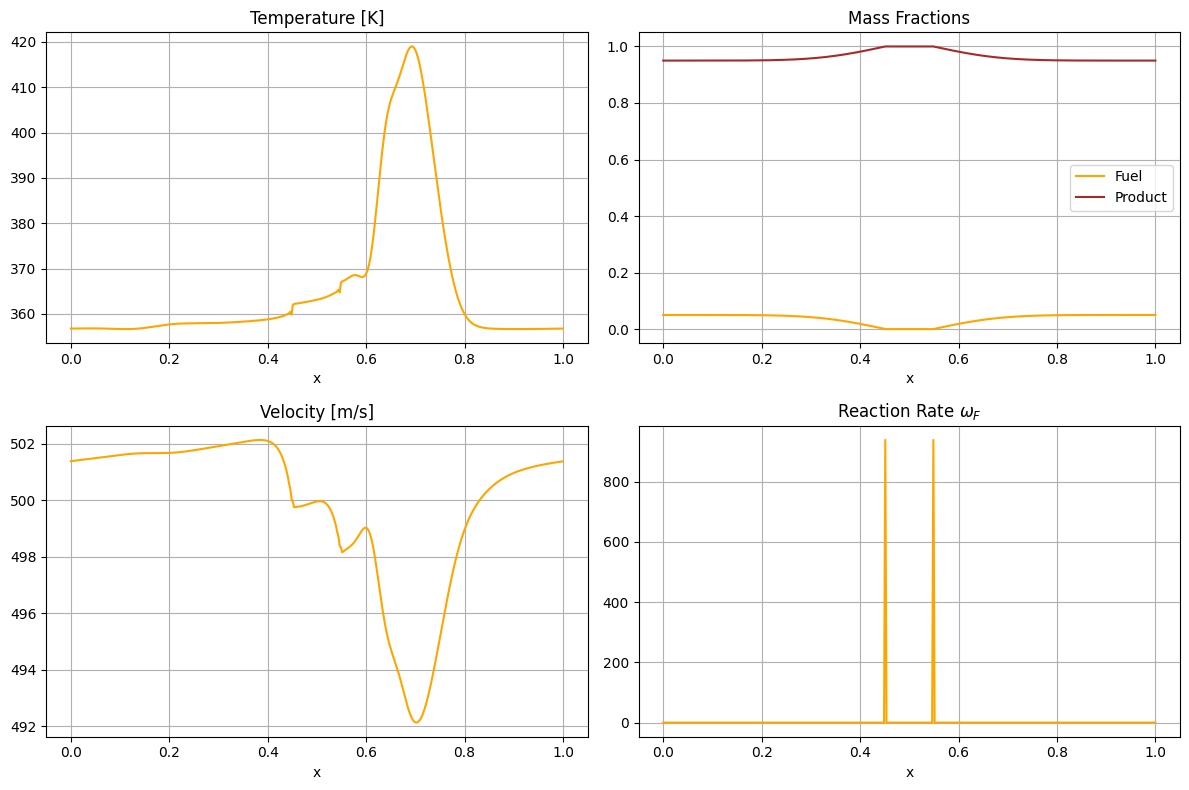

In [2]:
# Plot results
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(x, T, color='orange'); axs[0, 0].set_title('Temperature [K]')
axs[0, 1].plot(x, Y_F, label='Fuel', color='orange')
axs[0, 1].plot(x, Y_P, label='Product', color='brown')
axs[0, 1].set_title('Mass Fractions'); axs[0, 1].legend()
axs[1, 0].plot(x, u, color='orange'); axs[1, 0].set_title('Velocity [m/s]')
axs[1, 1].plot(x, omega, color='orange'); axs[1, 1].set_title('Reaction Rate $\omega_F$')
for ax in axs.flat:
    ax.set_xlabel('x')
    ax.grid()
plt.tight_layout()
plt.show()